In [1]:
from PIL import Image
from scipy.io import wavfile
import sys
from pathlib import Path
import os
import matplotlib.pyplot as plt

sys.path.insert(1, Path().resolve().parent.as_posix())

from audiojpeg import encoding

Encode audio and images at different JPEG quality levels.

In [2]:
original_img = Image.open("../data/mandril_color.tif")
audio_path = "../data/PinkPanther30.wav"

for quality in (100, 90, 50, 1):
    img_path = f"../output/PinkPanther30_{quality}.jpg"

    encoded = encoding.encode_wav_to_image(audio_path, order="F")
    Image.fromarray(encoded).save(img_path, quality=quality, subsampling=0)
    recovered = encoding.decode_image_to_audio(img_path).astype("int16")
    wavfile.write(f"../output/PinkPanther30_{quality}.wav", rate=22050, data=recovered)

    original_img.save(f"../output/test_img_{quality}.jpg", quality=quality, subsampling=0)

Decode images back to audio and calculate compression rates.

In [3]:
sampling_rate, original_audio = wavfile.read(audio_path)
original_size = os.path.getsize(audio_path)

compressed = {}
for quality in (100, 90, 50, 1):
    recovered_audio_path = Path(f"../output/PinkPanther30_{quality}.wav")
    encoded_image_path = Path(f"../output/PinkPanther30_{quality}.jpg")
    _, recovered_audio = wavfile.read(recovered_audio_path)

    encoded_size = os.path.getsize(encoded_image_path)
    # The metadata got corrupted for quality 1, so we need to remove the padding samples
    recovered_audio = recovered_audio[:len(original_audio)]
    
    compressed[quality] = {
        "audio": recovered_audio,
        "compression": original_size / encoded_size,
    }

Plot waveforms for each quality level, compared to the original.

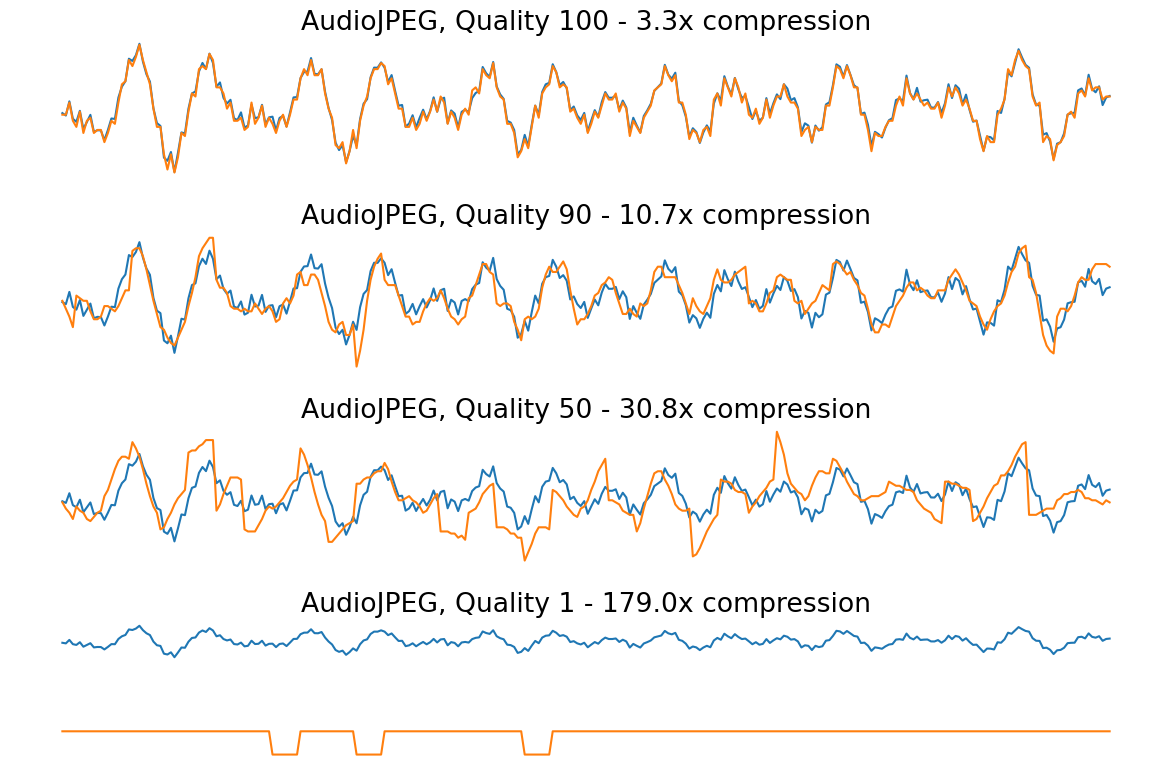

In [4]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

plot_samples = 300
start_sample = 60000

plt.rcParams.update({'font.size': 16})

for i, quality in enumerate((100, 90, 50, 1)):
    ax[i].plot(original_audio[start_sample:start_sample + plot_samples], label="Original")
    ax[i].plot(compressed[quality]["audio"][start_sample:start_sample + plot_samples], label=f"Quality {quality}")
    ax[i].set_title(f"AudioJPEG, Quality {quality} - {compressed[quality]['compression']:.1f}x compression")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
# Hide figure border
for a in ax:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["bottom"].set_visible(False)
    a.spines["left"].set_visible(False)

plt.tight_layout()
plt.savefig("../output/audiojpeg_compression.png", dpi=150, bbox_inches="tight")

Plot the MP3 waveform compared to the original.

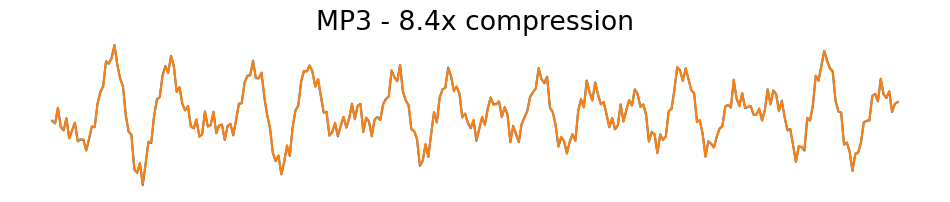

In [5]:
mp3_audio_path = Path("../data/PinkPanther30_via_mp3.wav")
_, mp3_audio = wavfile.read(mp3_audio_path)
mp3_size = os.path.getsize(Path("../data/PinkPanther30.mp3"))


fig, ax = plt.subplots(1, 1, figsize=(12, 2))

ax.plot(original_audio[start_sample:start_sample + plot_samples], label="Original")
ax.plot(mp3_audio[start_sample:start_sample + plot_samples], label="MP3")
ax.set_title(f"MP3 - {original_size / mp3_size:.1f}x compression")
# Hide x and y axis
ax.set_xticks([])
ax.set_yticks([])
# Hide figure border
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.savefig("../output/mp3_compression.png", dpi=150, bbox_inches="tight")